<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe30338-2021](https://jckantor.github.io/cbe30338-2021);
content is available [on Github](https://github.com/jckantor/cbe30338-2021.git).*


<!--NAVIGATION-->
< [3.3 Relay Control](https://jckantor.github.io/cbe30338-2021/03.03-Relay-Control.html) | [Contents](toc.html) | [3.5 Proportional (P) and Proportional-Integral (PI) Control](https://jckantor.github.io/cbe30338-2021/03.05-Proportional-Integral-Control.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/03.04-Implementing-Controllers.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/03.04-Implementing-Controllers.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 3.4 Implementing Controllers in Python

One of the challenges we will face is implementing complex control algorithms within the real-time event loop. Up to this point we have been doing the control calculations directly inside the event loop. This can work well for simple applications, like relay control for a single control variable. But for more complex algorithms and applications, this becomes completely unworkable. Placing the code for complex control algorithms directly in the event loop makes puts an undue burden on the coder to maintain all details of controller and system operation.

What we seek are coding techniques that can encapusulate control algorithms into separate, self-contained blocks of code where they can be developed, tested, and deployed. This notebook introduces three techniques for implementing controllers in testable, modular fashion:

* Nested Python functions
* Python generators
* Python classes

What these techniques have in common is creating blocks of code that maintain their own state, a requirement for useful control algorthms. 

The first of these, nested Python functions, exploits the ability of Python to return a function from another function. The 'outer' function accepts parameters specifying a desired controller and returns an 'inner' function that implements the controller. By using the Python `nonlocal`, the inner function can modify variables introduced in the outer function, and thereby accumulate and retain information. The use of nested functions builds on what most coders already know about Python.

Python generators provide a more flexible framework for implementing Python co-routines. Generators use the Python `yield` statement to communication data to and from and co-routine. Generators may be a less familiar for many Python coders, but with just a few new keywords and concepts, generators provide a framework with wide range of coding applications. Python generators are a clear and concise way of implementing control algorithms.

Finally, Python classes provide even more flexibility by allowing the use of object oriented programming. This is more overhead than is required from simple control algorithms, but are key to the robust implementation of more complex systems.

This notebook demonstrates these three different approaches to controller implementation. A reader new to Python coding may wish to limit their attention to the first two, nested functions and generators, and leave the more involved aspects of object-oriented coding the Python classes for a later time.


## 3.4.1 The problem with coding controllers as simple functions

A function performing the duty of the controller does the calculations necessary to compute a new value of the manipulated variable, $MV_k$. For relay control with a deadzone, for example, the value of $MV_k$ is given 
\begin{align}
MV_{k} & = \begin{cases} 
    MV^{max} &\text{if $PV_k \leq SP_k$} - d\\
    MV^{min} & \text{if $PV_k \geq SP_k$} + d\\
    MV_{k-1} & \text{ otherwise}
    \end{cases}
\end{align}

where parameters $MV^{min}$, $MV^{max}$, and $d$ define a particular instance of the control algorithm. With known values for those parameters,  the current value of $MV_k$ is determined from process variable $PV_k$, setpoint $SP_k$, and the prior value $MV_{k-1}$.

Here is a simple Python function implementing relay control with deadzone.

In [25]:
def relay_with_deadzone(PV, SP, MV_prev, MV_min, MV_max, d):
    if PV <= SP - d:
        MV = MV_max
    elif PV >= SP + d:
        MV = MV_min
    else:
        MV = MV_prev
    return MV

Now let's put it to work.

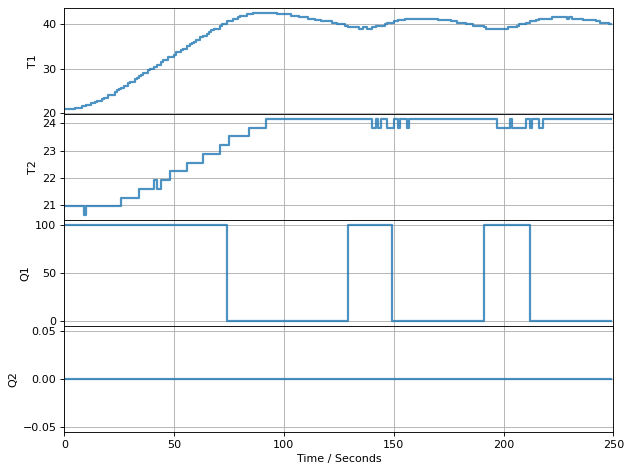

TCLab Model disconnected successfully.


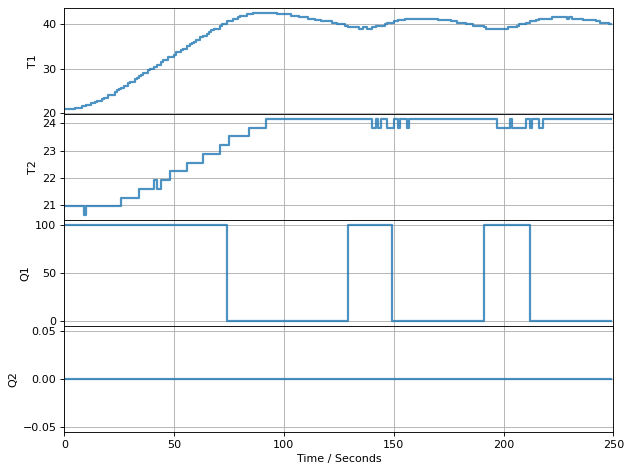

In [26]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

TCLab = setup(connected=False, speedup=20)

# control parameters
U_min = 0
U_max = 100
T_SP = 40
d = 0.5

# time horizon and time step
t_final = 250

# perform experiment
with TCLab() as lab:
    lab.P1 = 200
    h = Historian(lab.sources)
    p = Plotter(h, t_final)
    U1 = U_min
    for t in clock(t_final):
        T1 = lab.T1
        U1 = relay_with_deadzone(T1, T_SP, U1, U_min, U_max, d)
        lab.Q1(U1)
        p.update(t)      

Let's consider how this implementation would be extended to complex process applications with more controllers.

* If multiple controllers are required, the parameter values for every controller must be available in the event loop.
* Because the state of Python functions are lost after a `return` statement, any information required by a controller for the next update must be managed in the event loop. The information that needs to be retained depends on the details of the selected controllers.
* Any change to a controller implementation requires revision of the event loop, including possible changes to the information retained between updates.

This tight couplineg of the controller implementation, information management, and process operation would present very difficult challenges for the design and maintenance of control systems.

## 3.4.2 What we seek in a controller implementation

What we seek in controller implementations are features that facilitate the coding and maintenance of complex control systems and algorithms. Ideally, the code would "containerize" the controllers so that:

* Multiple instances of generic control algorithms can be created with unique parameter value.
* Controller instances maintain their own state. 

The second point is crucial. We would like to separate to write control code without requiring the event-loop to be responsible for everything.

## 3.4.3 Implementating relay control as nested function

In [35]:
def relay_with_deadzone(MV_min, MV_max, d):
    MV = MV_min
    def update(PV, SP):
        nonlocal MV
        if PV <= SP - d:
            MV = MV_max
        elif PV >= SP + d:
            MV = MV_min
        return MV
    return update

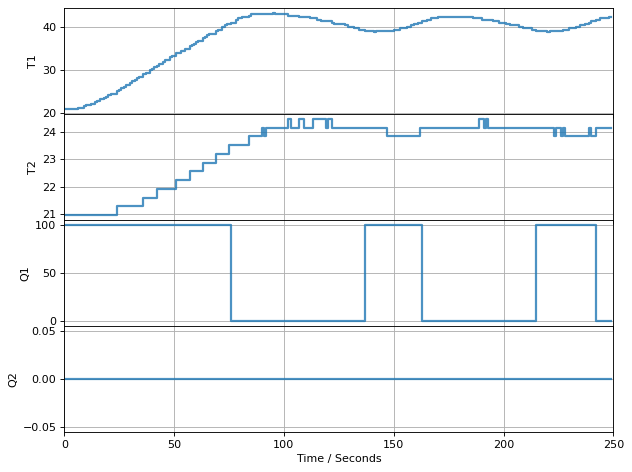

TCLab Model disconnected successfully.


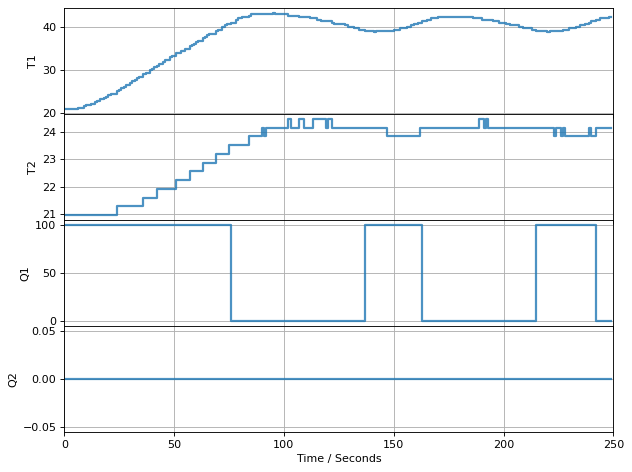

In [36]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

TCLab = setup(connected=False, speedup=20)

# control parameters
controller = relay_with_deadzone(MV_min=0, MV_max=100, d=1)
T_SP = 40

# time horizon and time step
t_final = 250

# perform experiment
with TCLab() as lab:
    lab.P1 = 200
    h = Historian(lab.sources)
    p = Plotter(h, t_final)
    for t in clock(t_final):
        T1 = lab.T1
        U1 = controller(T1, T_SP)
        lab.Q1(U1)
        p.update(t)      

## 3.4.4 Implementing relay control as a Python generator

### 3.4.4.1 What is a Python generator?

Values are returned from Python functions using the `return` statement. Once the return statement is encountered, the function is over and all local information is lost.

In [1]:
def my_function():
    return "Hello, World"

print(my_function())

Hello, World


Values are returned from generators with a `yield` statement. But what makes a generator different is that operation can be restarted to produce values from more `yield` statements. (Functions are 'one and done', generators come back for another season.)  

Because generators can be called multiple times, there are some extra details involved with their use:

* An 'instance' of the generator must be created before it can be used,
* The Python function `next()` gets the value returned by the next yeild statement.

In [8]:
def my_generator():
    yield "Hello, World"
    yield "Hello, again"
    yield "And one last thing ..."

# create an instance of the generator
f = my_generator()

# get values from the generator
print(next(f))
print(next(f))
print(next(f))

Hello, World
Hello, again
And one last thing ...


You can create multiple instances of generators, each maintaining its own state. 

In [14]:
def my_dog(dog):
    yield f"Hello {dog}"
    yield f"Go fetch {dog}"
    yield f"Come back {dog}"

f = my_dog("Spot")
g = my_dog("Rover")

print(next(f))
print(next(g))
print(next(g))
print(next(f))

Hello Spot
Hello Rover
Go fetch Rover
Go fetch Spot


In [27]:
def my_gen():
    msgs = []
    while True:
        msg = yield f"Hello {msgs}"
        msgs.append(msg)

f = my_gen()
next(f)

msg = f.send("Rover")
print(msg)

msg = f.send("Spot")
print(msg)

Hello ['Rover']
Hello ['Rover', 'Spot']


This behavior has a number very useful implications. The first thing is that we can create multiple instances of a generator, each with it's own parameters.

In [58]:
g10 = my_generator(10)
g20 = my_generator(20)

print(next(g10))
print(next(g10))
print(next(g20))
print(next(g10))
print(next(g20))
print(next(g20))

100
121
400
144
441
484


The second important implication is that each instance of a generator can maintain its own state in the form of local variables.

In [59]:
def infinite_counter():
    i = 0
    while True:
        yield i
        i = i + 1
        
f = infinite_counter()
print(next(f))
print(next(f))
print(next(f))
print(next(f))

0
1
2
3


We can also send information to a generator. 

In [71]:
def make_power(n):
    k = 0
    while True:
        val = yield k**n
        k = val
        
cube = make_power(3)
print(cube.send(None))
print(cube.send(2))
print(cube.send(12))

0
8
1728


### 3.4.4.2 Coding a relay controller as a Python generator

In [28]:
def Relay(MV_min=0, MV_max=100, d=0):
    MV = MV_min
    while True:
        PV, SP = yield MV
        if PV <= SP - d:
            MV = MV_max
        if PV >= SP + d:
            MV = MV_min

By coding the relay controller as a Python generator, we've eliminated the need to store the controller's parameters as global variable for our main program. This reduces the complexity of the code, and makes it possible. We have decoupled details of the control algorithm from the event loop. This is a big step forward to writing more modular, testable, and ultimately more reliable codes.

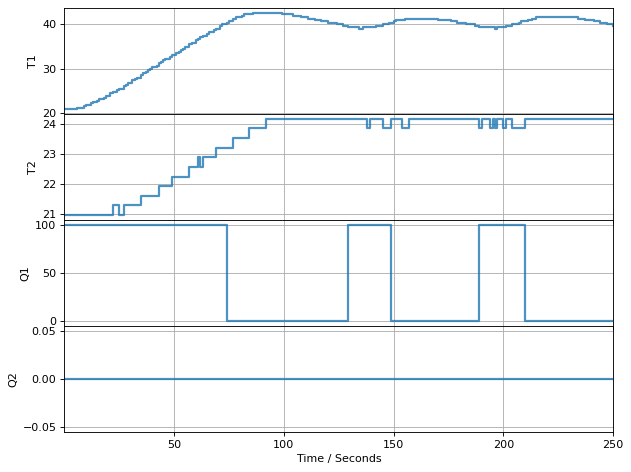

TCLab Model disconnected successfully.


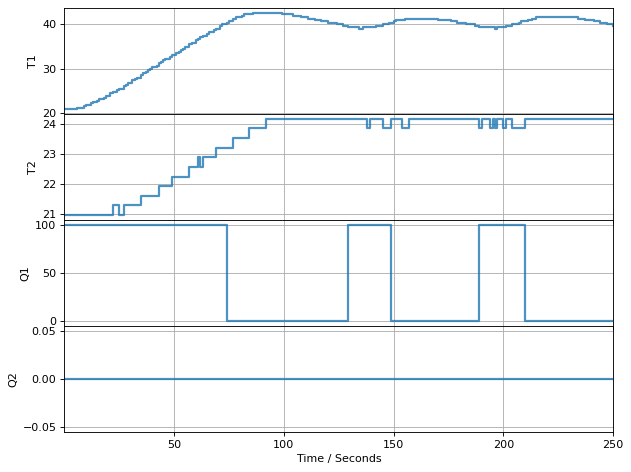

In [31]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

TCLab = setup(connected=False, speedup=20)

# control parameters
controller = Relay(MV_min=0, MV_max=100, d=0.5)
next(controller)
T_SP = 40

# time horizon and time step
t_final = 250

# perform experiment
with TCLab() as lab:
    lab.P1 = 200
    h = Historian(lab.sources)
    p = Plotter(h, t_final)
    for t in clock(t_final):
        T1 = lab.T1
        U1 = controller.send((T1, T_SP))
        lab.Q1(U1)
        p.update(t)    

## 3.4.5 Implementing relay control as a Python class

In [22]:
class Relay():
    def __init__(self, MV_min=0, MV_max=100, d=0):
        self.d = d
        self.MV_min = MV_min
        self.MV_max = MV_max
        self.d = d
        self.MV = self.MV_min
        
    def update(self, PV, SP):
        if PV <= SP - self.d:
            self.MV = self.MV_max
        if PV >= SP + self.d:
            self.MV = self.MV_min
        return self.MV

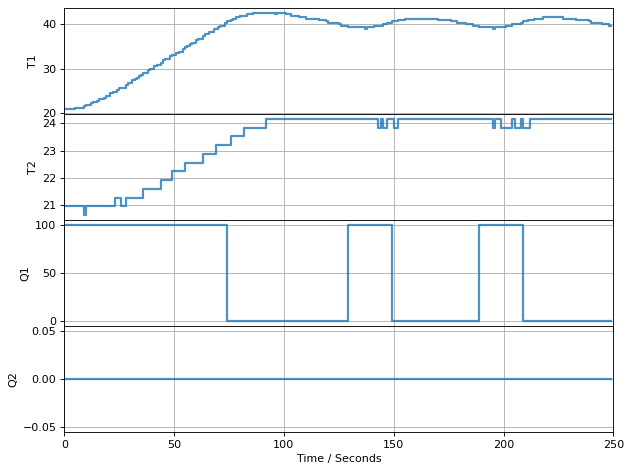

TCLab Model disconnected successfully.


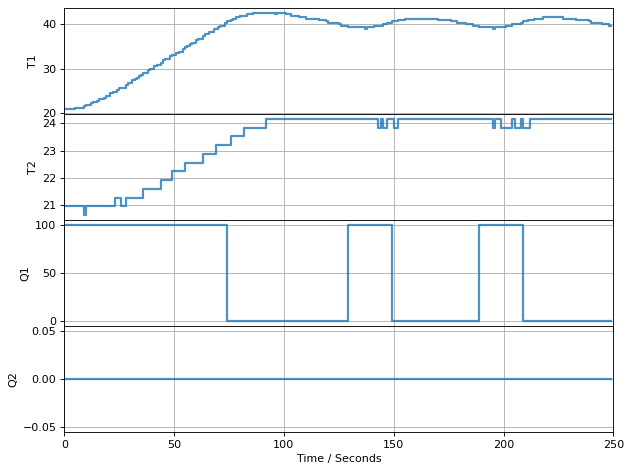

In [13]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

TCLab = setup(connected=False, speedup=20)

# control parameters
controller = Relay(MV_min=0, MV_max=100, d=0.5)
T_SP = 40

# time horizon and time step
t_final = 250

# perform experiment
with TCLab() as lab:
    lab.P1 = 200
    h = Historian(lab.sources)
    p = Plotter(h, t_final)
    for t in clock(t_final):
        T1 = lab.T1
        U1 = controller.update(T1, T_SP)
        lab.Q1(U1)
        p.update(t)      

<!--NAVIGATION-->
< [3.3 Relay Control](https://jckantor.github.io/cbe30338-2021/03.03-Relay-Control.html) | [Contents](toc.html) | [3.5 Proportional (P) and Proportional-Integral (PI) Control](https://jckantor.github.io/cbe30338-2021/03.05-Proportional-Integral-Control.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/03.04-Implementing-Controllers.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/03.04-Implementing-Controllers.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>